## Centralized Learning

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

data_key = 'ml-1m/'
# data_key = 'amz_Video_Games/'
# data_key = 'amz_Books/'
PROCESSED_DATA_ROOT = "/home/sl1471/workspace/experiments/"
target_path = PROCESSED_DATA_ROOT + data_key
# result_file_path = target_path + "results/" + "20211112_204803.csv"

In [5]:
import numpy as np
np.random.randn(10)

array([-0.48367424, -0.55536525, -0.82988366, -0.9552482 ,  0.3798564 ,
       -0.11393221,  1.81895891, -1.02842375,  0.03225056, -0.24798826])

In [2]:
from utils import extract_results
log_path = target_path + "logs/"
control_args = ['emb_size','aggregation_func','n_local_step','n_neg','l2_coef','lr','loss']
results = extract_results(log_path, control_args)
print(results)

16it [00:00, 69.92it/s]

{0: {'args': "cuda=0, seed=9, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/MF_lr0.00003_reg0.1_pairwisebpr.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.vocab', n_neg=1, n_neg_val=100, n_neg_test=-1, n_round=3, optimizer='SGD', epoch=30, check_epoch=1, lr=3e-05, batch_size=512, eval_batch_size=1, temper=6,

In [3]:
import numpy as np
metrics = ["AUC", "MR", "MRR"]
for m_name in ['HR', 'RECALL', 'P', 'F1', 'NDCG']:
    metrics += [f"{m_name}@{i}" for i in [1,5,10,20,50]]
for m_name in metrics:
    for k, res_dict in results.items():
        if m_name in res_dict:
            res_dict[m_name] = np.median(res_dict[m_name])

In [4]:
import pandas as pd
df = pd.DataFrame.from_dict(results, orient = 'index')

In [5]:
import os
import datetime
try:
    os.mkdir(target_path + "results/")
except:
    print("Dir exists: '" + target_path + "results/'")
result_file_path = target_path + "results/" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".csv"
df.to_csv(result_file_path, sep = '\t')

Dir exists: '/home/sl1471/workspace/experiments/ml-1m/results/'


In [6]:
df

,args,model_name,emb_size,aggregation_func,n_local_step,n_neg,l2_coef,lr,loss,HR@1,...,F1@20,NDCG@20,HR@50,P@50,RECALL@50,F1@50,NDCG@50,MR,MRR,AUC
0,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,0.10,0.00003,pairwisebpr,0.079765,...,0.047322,0.072159,0.627131,0.041417,0.132399,0.053326,0.092019,75.514839,0.019884,0.833106
1,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,0.01,0.00003,pairwisebpr,0.080523,...,0.047335,0.072201,0.626753,0.041455,0.132610,0.053373,0.092061,75.551491,0.019899,0.833009
2,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,0.00,0.00010,pairwisebpr,0.080523,...,0.047396,0.072307,0.626753,0.041470,0.132605,0.053383,0.092089,75.441607,0.019918,0.833276
3,"cuda=3, seed=9, train=False, train_and_eval=Tr...",FedMF,32,fedavg,5,1,0.01,1.00000,pairwisebpr,0.016673,...,0.016686,0.023279,0.489390,0.023551,0.075844,0.030345,0.043189,77.193129,0.008858,0.826306
4,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,1.00,0.00030,pairwisebpr,0.078060,...,0.047415,0.071742,0.627700,0.041349,0.132572,0.053266,0.091647,76.774201,0.019628,0.830084
5,"cuda=-1, seed=9, train=False, train_and_eval=T...",FedMF,32,fedavg,7,1,0.01,1.00000,pairwisebpr,0.013263,...,0.016529,0.023627,0.495453,0.023577,0.075846,0.030412,0.043808,77.429298,0.008879,0.825894
6,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,0.01,0.00030,pairwisebpr,0.079386,...,0.047385,0.072194,0.626563,0.041429,0.132361,0.053333,0.091892,75.250646,0.019828,0.833778
7,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,0.00,0.00030,pairwisebpr,0.080333,...,0.047354,0.072208,0.626563,0.041463,0.132461,0.053370,0.092087,75.283054,0.019908,0.833689
8,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,0.10,0.00010,pairwisebpr,0.077870,...,0.047323,0.071742,0.626753,0.041357,0.132266,0.053266,0.091513,75.317627,0.019597,0.833610
10,"cuda=0, seed=9, train=False, train_and_eval=Tr...",MF,32,NaN,NaN,1,0.10,0.00030,pairwisebpr,0.054377,...,0.040095,0.058252,0.624100,0.040576,0.127046,0.051952,0.081730,75.244641,0.015535,0.833924


In [7]:
def extract_performance(df, model_name, control_field, metrics, condition = {}):
    subdf = df[df['model_name'] == model_name]
    result_dict = {m:{} for m in metrics} # {metric_name: {#interest: value}}
    for i,row in subdf.iterrows():
        control = row[control_field]
        ignore = False
        for cond_key, cond_value in condition.items():
            if cond_key not in row or row[cond_key] != cond_value:
                ignore = True
                break
        if ignore:
            continue
        for m in metrics:
            if control not in result_dict[m]:
                result_dict[m][control] = []
            result_dict[m][control] += [row[m]]
    return result_dict

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_nominal_statistics(stats, features, ncol = 3, is_ordinal = False):
    '''
    @input:
    - stats: {field_name: {key: [values]}}
    - features: [field_name]
    - ncol: number of subplots in each row
    '''
    assert ncol > 0
    N = len(features)
    plt.figure(figsize = (16, 4*((N-1)//ncol+1)))
    for i,field in enumerate(features):
        plt.subplot((N-1)//ncol+1,ncol,i+1)
        field_stats = stats[field] # {key: [values]}
        X = list(field_stats.keys())
        if is_ordinal:
            X = sorted(X)
        Y = [np.mean(field_stats[x]) for x in X]
        X_label = np.arange(len(X))
        plt.bar(X_label,Y)
        plt.xticks(X_label,X)
        plt.title(field)
        scale = 1e-7 + np.max(Y) - np.min(Y)
        plt.ylim(np.min(Y) - scale * 0.05, np.max(Y) + scale * 0.05)
    plt.show()

In [11]:
import pandas as pd
df = pd.read_csv(result_file_path, sep='\t')
metrics = []
for m_name in ['HR', 'RECALL', 'P', 'F1', 'NDCG']:
    metrics += [f"{m_name}@{i}" for i in [1,5,10,20,50]]
metrics += ["AUC", "MR", "MRR"]
result = extract_performance(df, 'FedMF', "n_local_step", metrics, {"loss": "pairwisebpr", "l2_coef": 0.01, "lr": 1, "n_neg": 1})
result

{'HR@1': {5.0: [0.0166729821902235],
  7.0: [0.013262599469496],
  9.0: [0.011178476695718]},
 'HR@5': {5.0: [0.0850701023114816],
  7.0: [0.0843122394846532],
  9.0: [0.0831754452444107]},
 'HR@10': {5.0: [0.1311102690413035],
  7.0: [0.1312997347480106],
  9.0: [0.1364153088291019]},
 'HR@20': {5.0: [0.2243273967411898],
  7.0: [0.2209170140204623],
  9.0: [0.224706328154604]},
 'HR@50': {5.0: [0.4893899204244031],
  7.0: [0.4954528230390299],
  9.0: [0.495642288745737]},
 'RECALL@1': {5.0: [0.0010869341094982],
  7.0: [0.0009170476895626],
  9.0: [0.0009220691810511]},
 'RECALL@5': {5.0: [0.0059869656072489],
  7.0: [0.005531585337093],
  9.0: [0.0055753233027865]},
 'RECALL@10': {5.0: [0.0118533912622632],
  7.0: [0.0111137565908062],
  9.0: [0.0118536107138352]},
 'RECALL@20': {5.0: [0.0234235207156383],
  7.0: [0.022836150893537],
  9.0: [0.0235308868219061]},
 'RECALL@50': {5.0: [0.0758443051127222],
  7.0: [0.0758460911393854],
  9.0: [0.075691838743283]},
 'P@1': {5.0: [0.0166

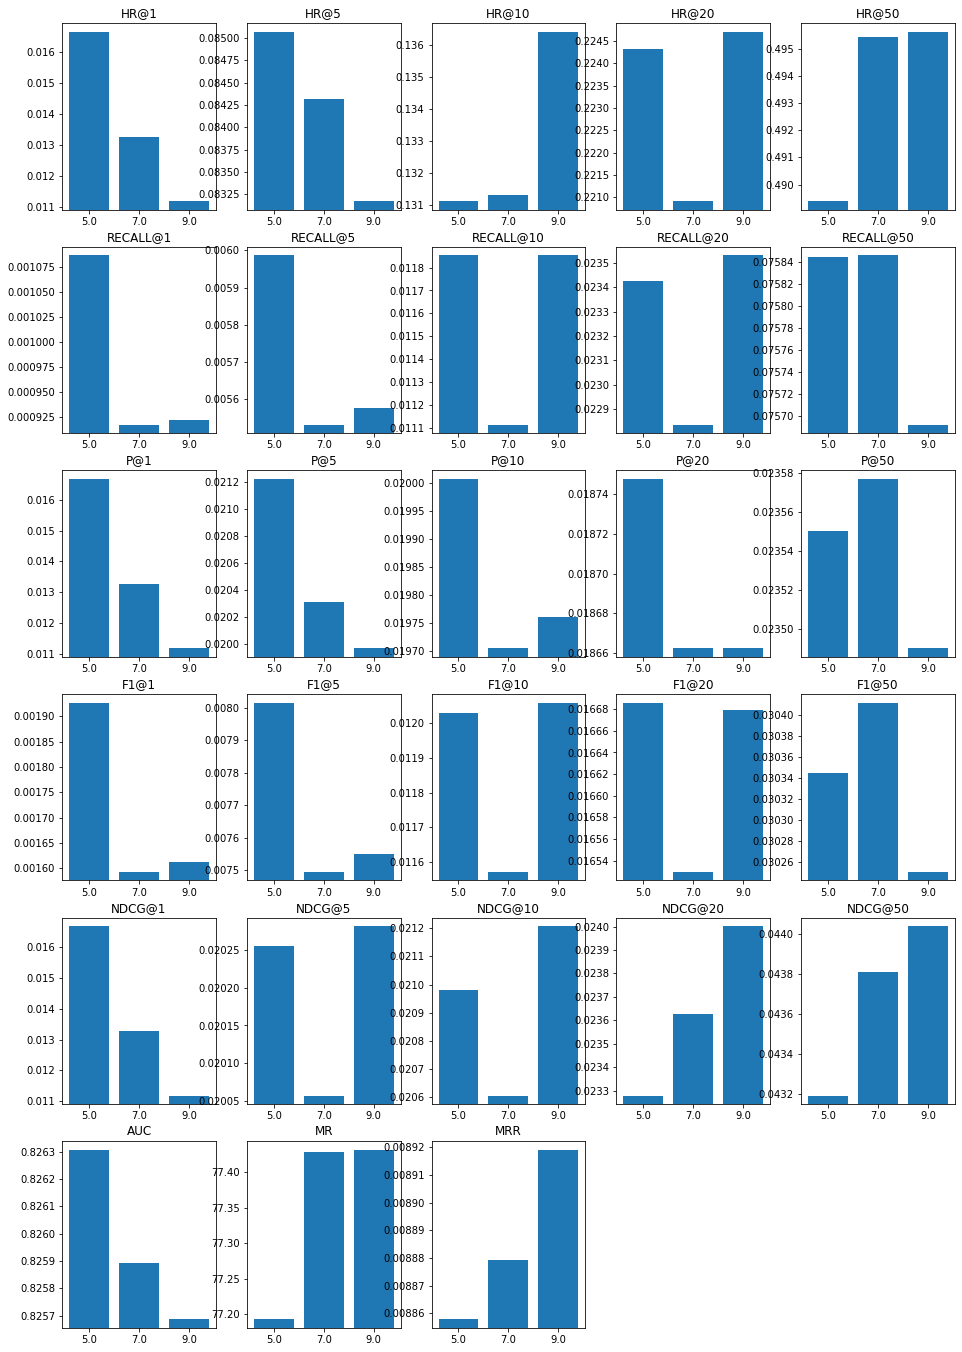

In [12]:
plot_nominal_statistics(result, metrics, ncol = 5, is_ordinal = True)

In [14]:
"102" < "101"

False

In [15]:
for i in range(2,1):
    print(i)

In [23]:
import torch
a = torch.tensor([1])
a

tensor([1])

In [27]:
a.reshape(-1).numpy()[0]

1